In [1]:
!pip install phik
!pip install lightgbm

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<div> <b>Цель исследования:</b><br>
    1. Построить различные модели предсказания стоимости автомобиля <br>
    2. Сравнить время обучения, время предсказания и точность моделей<br>
    3. Добиться значения RMSE ниже 2500<br><br>
    <b>Ход исследования:</b><br>
    1. Загрузка и пердобработка данных<br>
    2. Построение моделей<br>
    <ul>
         <li>LinearRegression</li>
         <li>RandomForest</li>
         <li>LightGBM</li>
         <li>CatBoost</li>
    </ul>
    3. Пулучение нужного результата и анализ моделей<br>
    </div>

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from phik import resources, report
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor


In [3]:
df = pd.read_csv('autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.DateCrawled = pd.to_datetime(df.DateCrawled)
df.DateCreated = pd.to_datetime(df.DateCreated)
df.LastSeen = pd.to_datetime(df.LastSeen)

In [5]:
df.DateCrawled.sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
176823   2016-03-05 14:06:24
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: DateCrawled, Length: 354369, dtype: datetime64[ns]

Дата скачивания анкеты и дату последней активности считаю не информативными признаками.

In [6]:
df = df.drop(['DateCrawled', 'LastSeen'], axis=1)

In [7]:
df.NumberOfPictures.unique()

array([0], dtype=int64)

Количество картинок везде 0.Удалим признак.

In [8]:
df = df.drop('NumberOfPictures', axis=1)

In [9]:
df.sort_values('DateCreated').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
61207,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10,79669
4001,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20,24558
342275,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18,76275
86601,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07,76228
175103,5200,convertible,2006,manual,109,2_reihe,80000,11,petrol,peugeot,no,2015-08-10,26382


Удалим устаревшие объявления (за 2015 год и раньше).

In [10]:
df = df[df['DateCreated']>datetime(2015, 12, 31)].reset_index(drop=True)

Удалим объявления со слишком низкой ценой.

<AxesSubplot:>

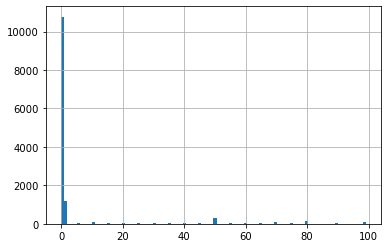

In [11]:
df[df['Price']<100].Price.hist(bins=100)

In [12]:
df = df[df['Price']>1].reset_index(drop=True)

Возможно тут стоит отрезать побольше.

Я удалил 0 и 1, и имел в виду что возможно стоит отрезать например до 100 евро(примерно столько стоит металолом, возможно в Германии другие цены и надо ещё приплачивать за то чтоб машину вывезли).

Заменим пропуски в типе кузова.

<AxesSubplot:>

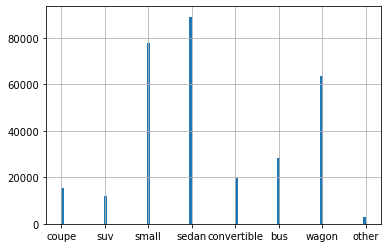

In [13]:
df.VehicleType.hist(bins=100)

In [14]:
df.loc[df['VehicleType'].isna(),'VehicleType'] = 'other'

Почистим год регистрации. Оставим значения только за последние 30 лет. Более ранние авто могут быть раритетом.

<ul>
         <li>Есть некоторое количество неадекватно маленьких чисел в этой графе.</li>
         <li>Всего автомобилей старше 30 лет не много</li>
         <li>Если рассматривать старые авто, то, считаю, что раритет от металлолома можно отличить только по более детальным признакам(например фото, которых у нас нет)</li>

</ul>

In [15]:
df = df[(df['RegistrationYear']<2017) &(df['RegistrationYear']>=2017-30)]

<AxesSubplot:>

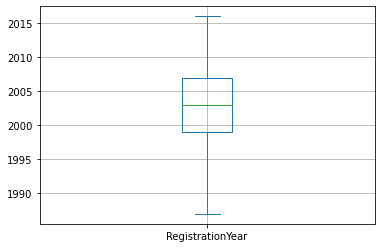

In [16]:
df.RegistrationYear.plot.box(grid=True)

Посмотрим на тип коробки передач. Заполним пустые ячейки более частым значением.

<AxesSubplot:>

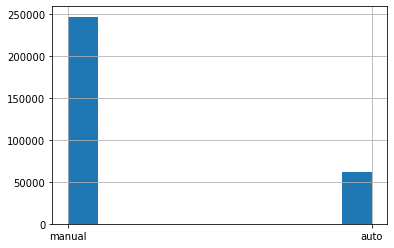

In [17]:
df.Gearbox.hist()

In [18]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = 'manual'

Посмотрим на мощность. Удалим выбибвающиеся значения.

In [19]:
df.sort_values('Power').tail()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
61819,3250,sedan,2001,auto,17932,omega,150000,6,petrol,opel,NaN,2016-03-28,86641
127972,2100,wagon,2001,manual,19208,5er,150000,5,NaN,bmw,yes,2016-03-25,59556
110226,9999,sedan,2006,manual,19211,1er,125000,0,gasoline,bmw,NaN,2016-04-03,45964
289029,1500,wagon,1997,manual,19312,5er,150000,1,NaN,bmw,no,2016-03-09,21129
212067,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09,19406


<AxesSubplot:>

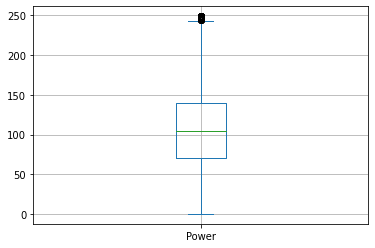

In [20]:
df[df['Power']<250].Power.plot.box(grid=True)

In [21]:
df = df[df['Power']<250].reset_index(drop=True)

Машины с 0-ой мощностью могут быть просто без двигателя, либо двигатель уже не подлежит восстановлению.

Заполним пустые ячейки в колонке модель на название марки автомобиля. 

In [22]:
df.loc[(df['Model'].isna())|(df['Model']=='other'), 'Model'] = df['Brand']

Посмотрим на пробег.

<AxesSubplot:>

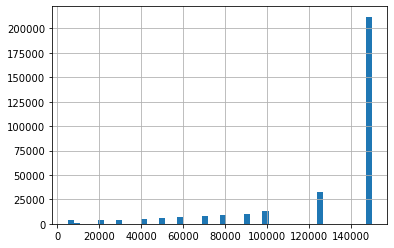

In [23]:
df.Kilometer.hist(bins=50)

Тут ничего неожиданного, в основном автомобили с большим пробегом.

Посмотрим на месяц регистрации.

In [24]:
df.RegistrationMonth.unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

Видимо 0 означет пропуск.

Заполним пропуски в колонке топливо на other.

In [25]:
df.loc[df['FuelType'].isna(), 'FuelType'] = 'other'

<AxesSubplot:>

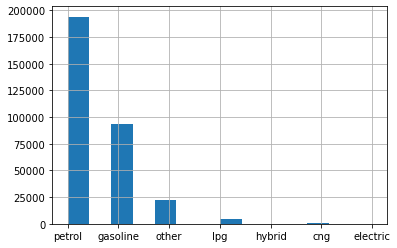

In [26]:
df.FuelType.hist(bins=14)

Странно, что нет дизелей.

Заполним пропуски в колонке Repaired на other(видимо, владелец не знает, была ли его машина в ремонте, или ремонт не значительный).

In [27]:
df.Repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

In [28]:
df.loc[df['Repaired'].isna(), 'Repaired'] = 'other'

Изменим значения колонки DateCreated на количество дней от 2016-01-01

In [29]:
df['DateCreated'] = (df['DateCreated'] - datetime(2016, 1, 1)).dt.days

Посмотрим на почтовые индексы. Судя по всему, это данные из Германии. Зону определяют первые две цифры.

In [30]:
df.pivot_table(index='PostalCode', values='Price', aggfunc='count').sort_values('Price',ascending=False).head()

,Price
PostalCode,
10115,732
65428,555
66333,303
32257,276
44145,270


In [31]:
df['PostalCode'] = df['PostalCode']//1000

In [32]:
df.pivot_table(index='PostalCode', values='Price', aggfunc='count').sort_values('Price',ascending=False).head()

,Price
PostalCode,
45,7417
26,6625
65,6385
66,6354
44,5797


interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'DateCreated', 'PostalCode']
interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'DateCreated', 'PostalCode']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
Price,1.000000,0.281572,0.708455,0.304666,0.498789,0.582442,0.329855,0.160973,0.292904,0.355065,0.357558,0.030457,0.090527
VehicleType,0.281572,1.000000,0.421529,0.268064,0.525235,0.910068,0.176278,0.185712,0.407518,0.624478,0.300771,0.022517,0.067741
RegistrationYear,0.708455,0.421529,1.000000,0.128608,0.311061,0.632852,0.443138,0.163501,0.317126,0.348361,0.273769,0.017260,0.083345
Gearbox,0.304666,0.268064,0.128608,1.000000,0.527494,0.606901,0.011454,0.056192,0.161019,0.481246,0.033404,0.005350,0.093277
Power,0.498789,0.525235,0.311061,0.527494,1.000000,0.796158,0.122467,0.232079,0.302185,0.589810,0.332351,0.010493,0.106877
Model,0.582442,0.910068,0.632852,0.606901,0.796158,1.000000,0.453590,0.171667,0.568185,0.999942,0.285145,0.056483,0.222393
Kilometer,0.329855,0.176278,0.443138,0.011454,0.122467,0.453590,1.000000,0.056759,0.153147,0.272378,0.235997,0.013981,0.038970
RegistrationMonth,0.160973,0.185712,0.163501,0.056192,0.232079,0.171667,0.056759,1.000000,0.190871,0.087265,0.274919,0.019824,0.045266
FuelType,0.292904,0.407518,0.317126,0.161019,0.302185,0.568185,0.153147,0.190871,1.000000,0.296489,0.244765,0.012302,0.054603
Brand,0.355065,0.624478,0.348361,0.481246,0.589810,0.999942,0.272378,0.087265,0.296489,1.000000,0.148139,0.024703,0.172623


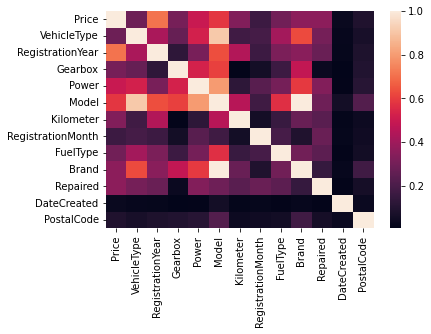

In [33]:
sns.heatmap(df.phik_matrix())
df.phik_matrix()

Удалим дубликаты.

In [34]:
df = df.drop_duplicates().reset_index(drop=True)

In [35]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode
count,305134.000000,305134.000000,305134.000000,305134.000000,305134.000000,305134.000000,305134.000000
mean,4424.803624,2003.074056,104.631460,128755.956399,5.830006,79.802585,50.360333
std,4394.973656,5.778100,55.135931,36972.584162,3.679450,9.203316,25.779952
min,2.000000,1987.000000,0.000000,5000.000000,0.000000,1.000000,1.000000
25%,1199.000000,1999.000000,70.000000,125000.000000,3.000000,72.000000,30.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,80.000000,49.000000
75%,6300.000000,2007.000000,140.000000,150000.000000,9.000000,88.000000,71.000000
max,20000.000000,2016.000000,249.000000,150000.000000,12.000000,97.000000,99.000000


## Обучение моделей

### Линейная модель
Заменим категориальные признаки 

In [36]:
df[['RegistrationMonth', 'PostalCode']] = df[['RegistrationMonth', 'PostalCode']].astype(str)

In [37]:
target = df['Price']
features = df.drop(['Price'] , axis=1)
features_train_1, features_test, target_train_1, target_test = train_test_split(
    features, target, test_size=0.1, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_1, target_train_1, test_size=0.2, random_state=12345)

In [38]:
ohe = OneHotEncoder(drop='first')
ohe.fit(features_train.select_dtypes('object'))
X_train = (features_train.select_dtypes('int64').reset_index(drop=True)
    .join(pd.DataFrame(ohe.transform(features_train.select_dtypes('object')).toarray())))
X_train.columns = X_train.columns.astype('str')
model_lin = Ridge()

In [39]:
%%time
model_lin.fit(X_train, target_train)

CPU times: total: 8.44 s
Wall time: 2.46 s


Ridge()

Отрицательные предсказания заменим на 0.

In [40]:
X_valid = (features_valid.select_dtypes('int64').reset_index(drop=True)
    .join(pd.DataFrame(ohe.transform(features_valid.select_dtypes('object')).toarray())))
X_valid.columns = X_valid.columns.astype('str')

In [41]:
%%time
pred = model_lin.predict(X_valid)

CPU times: total: 93.8 ms
Wall time: 88.7 ms


In [42]:
pred_lin = pd.Series(pred, name='pred_lin')
pred_lin[pred_lin<0] = 0
mean_squared_error(pred_lin, target_valid, squared=False)

2317.3208575943577

In [43]:
lin_parameters = {'fit':8, 'predict': 0.11, 'RMSE': 2317}

Линейная модель справилась довольно быстро и результат удовлетворяет поставленной задаче.

In [44]:
del (X_train, X_valid)

### Случайный лес
Применим порядковое кодирование.

In [45]:
target = df['Price']
features = df.drop(['Price'] , axis=1)
features_train_1, features_test, target_train_1, target_test = train_test_split(
    features, target, test_size=0.1, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_1, target_train_1, test_size=0.2, random_state=12345)

In [46]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [47]:
features_train = (features_train.select_dtypes('int64').reset_index(drop=True)
        .join(pd.DataFrame(oe.fit_transform(features_train.select_dtypes('object')), 
              columns=features_train.select_dtypes('object').columns)))
model_forest = RandomForestRegressor(max_depth = 12, n_estimators=15, random_state=12345)

In [48]:
%%time
model_forest.fit(features_train, target_train)

CPU times: total: 7.47 s
Wall time: 7.48 s


RandomForestRegressor(max_depth=12, n_estimators=15, random_state=12345)

In [49]:
features_valid = (features_valid.select_dtypes('int64').reset_index(drop=True)
        .join(pd.DataFrame(oe.transform(features_valid.select_dtypes('object')), 
              columns=features_valid.select_dtypes('object').columns)))

In [50]:
%%time
pred_forest = model_forest.predict(features_valid)

CPU times: total: 93.8 ms
Wall time: 99.9 ms


In [51]:
pred_forest = pd.Series(pred_forest, name='pred_forest')

In [52]:
mean_squared_error(pred_forest, target_valid, squared=False)

1657.8167124279323

In [53]:
forest_parameters = {'fit':7.5, 'predict': 0.09, 'RMSE': 1658}

In [54]:
forest_bf = pd.Series(model_forest.feature_importances_, index=features_train.columns, name='forest')

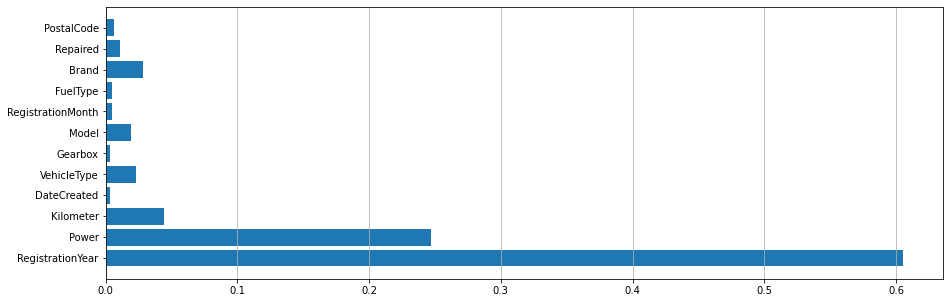

In [55]:
plt.figure(figsize=(15,5))
plt.barh(features_train.columns, model_forest.feature_importances_)
plt.grid(axis='x')

Не подбирая долго параметры, уже удалось получить более высокую точность предсказания и высокую скорость обучения модели.

Добавив категориальные признаки и усложнив модель можно получить более высокие результаты, но модель будет обучаться дольше.

In [56]:
del (features_train, features_valid)

### CatBoost

In [57]:
y = df['Price']
X = df.drop(['Price','PostalCode'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=12345)

Попробуем подобрать параметры.

In [58]:
grid = {'learning_rate': [0.3, 0.4, 0.5, 0.6],
        'depth': [ 8, 10, 12],
        'iterations': [100,200, 300]}

In [59]:
p = Pool(X_train,y_train, cat_features=X.select_dtypes('object').columns.values)

In [60]:
model_cat = CatBoostRegressor(verbose=100)

In [61]:
%%time
model_cat.grid_search(grid, p, train_size=0.9, plot=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
features_train, features_valid, target_train, target_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=12345)
model_cat_test = CatBoostRegressor(verbose=100,
                             depth=10,
                             iterations=300,
                             learning_rate=0.3)

In [63]:
%%time
model_cat_test.fit(X_train,y_train, cat_features=X.select_dtypes('object').columns.values
                        #, plot=True
                       )

0:	learn: 3439.8370777	total: 379ms	remaining: 1m 53s
100:	learn: 1372.9323782	total: 25.1s	remaining: 49.5s
200:	learn: 1291.5598847	total: 50.2s	remaining: 24.7s
299:	learn: 1234.7560637	total: 1m 15s	remaining: 0us
CPU times: total: 10min 42s
Wall time: 1min 16s


In [64]:
%%time
model_cat_test.predict(features_valid)

CPU times: total: 531 ms
Wall time: 114 ms


array([ 569.68394008,  778.66464499, 2309.90891601, ..., 4595.37616067,
       9330.77114577, 3044.45215679])

In [65]:
pred_cat = model_cat_test.predict(features_valid)
pred_cat = pd.Series(pred_cat, name='pred_cat')
pred_cat[pred_cat<0] = 0
mean_squared_error(pred_cat, target_valid, squared=False)

1292.8904659480643

In [66]:
cat_parameters = {'fit':80, 'predict': 0.5, 'RMSE': 1293}

In [67]:
model_cat.get_params()

{'loss_function': 'RMSE', 'verbose': 100}

In [68]:
Cat_bf = pd.Series(model_cat_test.feature_importances_, index=features_train.columns, name='Cat')

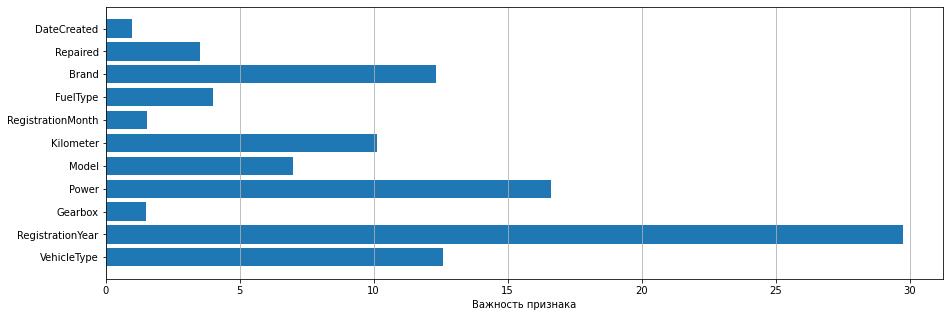

In [69]:
plt.figure(figsize=(15,5))
plt.xlabel('Важность признака')
plt.barh(X_train.columns, model_cat_test.feature_importances_)

plt.grid(axis='x')

С удачными параметрами модель обучается достаточно быстро и дает результат лучше 1500. Можно увеличить колличество итераций результат будет лучше, но обучение дольше. Также можно попробовать еще "поиграть" с параметрами.

In [70]:
del p

### LGBMRegressor
Пройдем все шаги также как с CatBoost.

In [71]:
y = df['Price']
X = df.drop(['Price'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=12345)

In [72]:
X_train = (X_train.select_dtypes('int64').reset_index(drop=True)
        .join(pd.DataFrame(oe.fit_transform(X_train.select_dtypes('object')))))

X_test = (X_test.select_dtypes('int64').reset_index(drop=True)
        .join(pd.DataFrame(oe.transform(X_test.select_dtypes('object')))))

Посмотрим как повлияют на результат разные параметры.

In [73]:
grid = {'learning_rate': [0.3, 0.4, 0.5, 0.6],
        'max_depth': [8, 10, 12],
        'n_estimators': [100,200, 300]}

In [74]:
model_LGBM = LGBMRegressor()
Grid_LGBM = GridSearchCV(estimator=model_LGBM, param_grid = grid, cv = 3, scoring='neg_mean_absolute_error', n_jobs=-1)

In [75]:
%%time
Grid_LGBM.fit(X_train,y_train)

CPU times: total: 15.6 s
Wall time: 46.9 s


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.4, 0.5, 0.6],
                         'max_depth': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error')

Модель обучалась дольше чем CatBoost и результат дала хуже.

In [76]:
Grid_LGBM.best_params_

{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 300}

In [77]:
print('Время обучения:',Grid_LGBM.cv_results_['mean_fit_time'][11])
print('Время предсказания:', Grid_LGBM.cv_results_['mean_score_time'][11])
print('RMSE:', Grid_LGBM.cv_results_['mean_test_score'][11])

Время обучения: 4.74933393796285
Время предсказания: 1.811752716700236
RMSE: -939.9786261984642


Модель обучается очень быстро и дала лучший результат.

In [78]:
y = df['Price']
X = df.drop(['Price'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=12345)

In [79]:
X_train = (features_train.select_dtypes('int64').reset_index(drop=True)
        .join(pd.DataFrame(oe.fit_transform(features_train.select_dtypes('object')), 
              columns=features_train.select_dtypes('object').columns)))

X_valid = (features_valid.select_dtypes('int64').reset_index(drop=True)
        .join(pd.DataFrame(oe.transform(features_valid.select_dtypes('object')), 
              columns=features_valid.select_dtypes('object').columns)))

model_LGBM_test = LGBMRegressor(learning_rate=0.3, max_depth=8, n_estimators=300)

In [80]:
%%time
model_LGBM_test.fit(X_train,target_train)

CPU times: total: 12.2 s
Wall time: 1.1 s


LGBMRegressor(learning_rate=0.3, max_depth=8, n_estimators=300)

In [81]:
%%time
model_LGBM_test.predict(X_valid)

CPU times: total: 1.02 s
Wall time: 102 ms


array([ 720.20077525, 1272.18647264, 2207.00357409, ..., 1604.54703406,
       3535.29292664, 2235.71597522])

In [82]:
pred_LGBM = model_LGBM_test.predict(X_valid)
pred_LGBM = pd.Series(pred_LGBM, name='pred_LGBM')
pred_LGBM[pred_LGBM<0] = 0
mean_squared_error(pred_LGBM, target_valid, squared=False)

1472.606296375218

In [83]:
LGBM_parameters = {'fit':11.5, 
                  'predict': 1.2, 
                  'RMSE': 1473}

In [84]:
LGBM_bf = pd.Series(model_LGBM_test.feature_importances_, index=X_train.columns, name='LGBM')

In [85]:
LGBM_bf

RegistrationYear     1439
Power                1645
Kilometer             715
DateCreated           552
VehicleType           595
Gearbox               159
Model                1232
RegistrationMonth     497
FuelType              296
Brand                 806
Repaired              190
PostalCode            874
Name: LGBM, dtype: int32

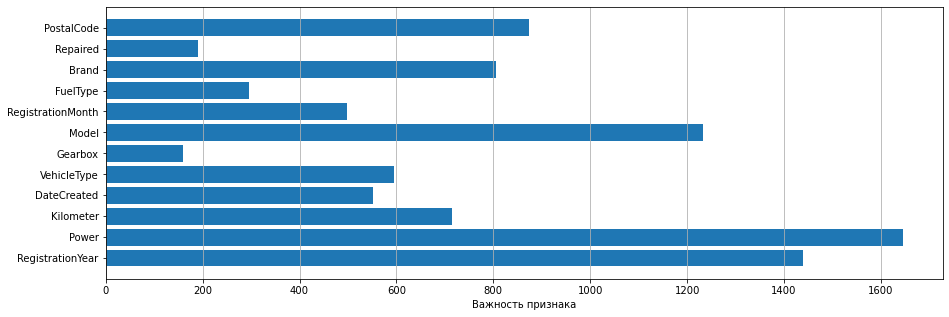

In [86]:
plt.figure(figsize=(15,5))
plt.xlabel('Важность признака')
plt.barh(X_train.columns, model_LGBM_test.feature_importances_)

plt.grid(axis='x')

LGBM обучилась быстрее чем CatBoost, но дала результат хуже.

## Анализ моделей
Сравним результаты моделей.

In [87]:
params = pd.DataFrame([lin_parameters, forest_parameters, cat_parameters, LGBM_parameters], index=['lin', 'forest', 'CatBoost', 'LGBM'])

In [88]:
params

,fit,predict,RMSE
lin,8.0,0.11,2317
forest,7.5,0.09,1658
CatBoost,80.0,0.50,1293
LGBM,11.5,1.20,1473


CatBoost обучался значительно дольше других моделей, возможно это связано с преобразованием признаков внутри модели. Также точность CatBoost оказалась максимальной, хотя на тесте различия оказались не столь существены. 
    
LGBM обучался быстрее других моделей, скорее всего из-за распараллеливания процесов. LGBM значительно дольше предсказывал, это объяснить не могу. 

In [89]:
bf = pd.DataFrame([LGBM_bf/3000, Cat_bf/100, forest_bf]).T

<AxesSubplot:>

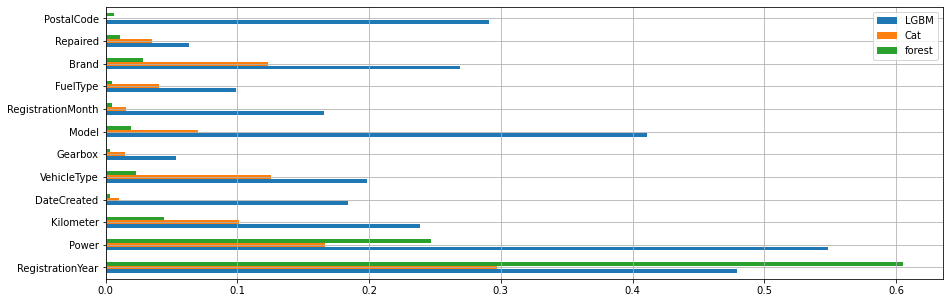

In [90]:
bf.plot(kind='barh',figsize=(15,5), grid=True)

Каждая модель по-разному выделяет важность признаков. Заметно что LGBM выбирает признаки более равномерно.

In [91]:
answers = target_valid.reset_index(drop=True)
answers = pd.DataFrame({'answers':answers, 
                      'pred_lin': pred_lin, 
                      'pred_forest': pred_forest, 
                      'pred_cat': pred_cat, 
                      'pred_LGBM': pred_LGBM})

In [92]:
answers = answers.sort_values('answers').reset_index(drop=True)

In [93]:
answers[answers==0] = 1

In [94]:
answers['pred_lin'].min()

0.06470270897261798

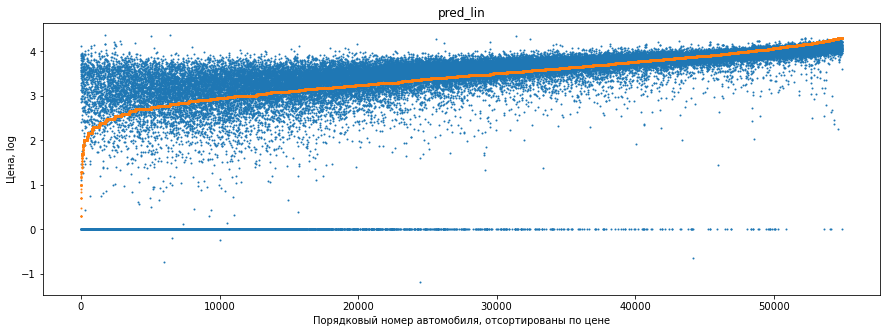

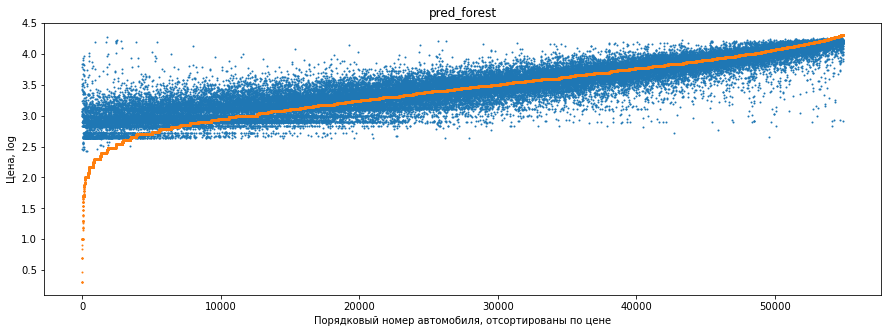

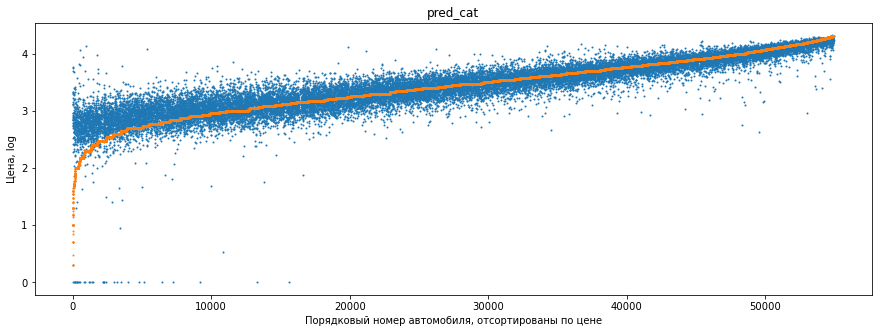

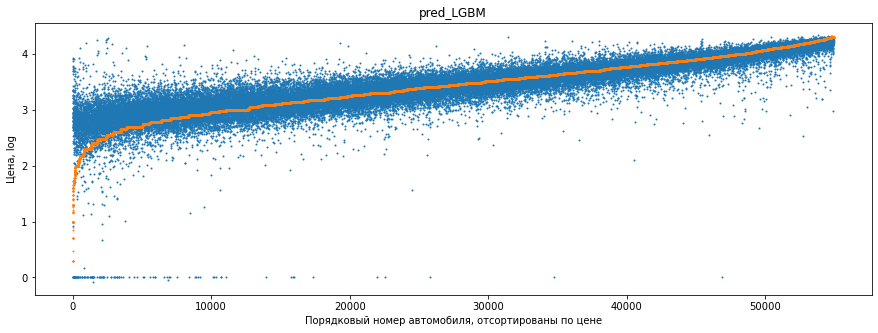

In [95]:
for i in answers.columns[1:]:
    plt.figure(figsize=(15,5))
    plt.xlabel('Порядковый номер автомобиля, отсортированы по цене')
    plt.ylabel('Цена, log')
    plt.plot(np.log10(answers[i]), 'o', markersize=1)
    plt.plot(np.log10(answers.answers), 'o', markersize=1)
    plt.title(i)

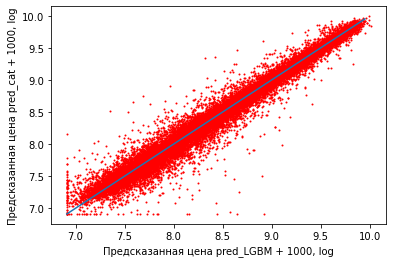

In [96]:
plt.xlabel('Предсказанная цена pred_LGBM + 1000, log')
plt.ylabel('Предсказанная цена pred_cat + 1000, log')
plt.plot(np.log(answers.pred_LGBM+1000),np.log(answers.pred_cat+1000), 'o', markersize=1, color='r')
plt.plot(np.log(answers.answers+1000),np.log(answers.answers+1000))

Заметно что предсказания моделей бустинга похожи, но имеют различия. Можно взять среднее между ними.

Но это увеличит время обучения и предсказания. Исходя из этого, выберем CatBoost, т.к. модель показала лучший результат и хорошую скорость предсказания(2 из 3 параметров).

In [97]:
y = df['Price']
X = df.drop(['Price','PostalCode'] , axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=12345)
model_cat_best_grid = CatBoostRegressor(verbose=100,
                             depth=10,
                             iterations=300,
                             learning_rate=0.3)
model_cat_best_grid.fit(X_train,y_train, cat_features=X.select_dtypes('object').columns.values
                        #, plot=True
                       )
pred_cat = model_cat_best_grid.predict(X_test)
pred_cat = pd.Series(pred_cat, name='pred')
pred_cat[pred_cat<0] = 0
mean_squared_error(pred_cat, y_test, squared=False)

0:	learn: 3439.8370777	total: 247ms	remaining: 1m 13s
100:	learn: 1372.9323782	total: 25s	remaining: 49.2s
200:	learn: 1291.5598847	total: 50.4s	remaining: 24.8s
299:	learn: 1234.7560637	total: 1m 16s	remaining: 0us


1425.5174727603642

Итого результат на тестовой выборке 1426.

Линейная регрессия очень плохо определяет цену, только дорогим автомобилям реже присваевается нулевая цена.

Случайный лес не определяет цену на краях выборки. Заметно "слежение" графика за истиными значениями.

Графики LGBM и CatBoost очень похожи. Дают большой разброс значений для автомобилей с низкой ценой. Возможно проставленая низкая цена в некоторых случаях является ошибкой данных. Обе модели неплохо отслеживают истиный график.

## Вывод
Были получены данные о подержанных автомобилях и их цене. Были отброшены устаревшие объявления и объявления без цены (с указанной ценой 0 и 1). Также не рассматривались автомобили старше 30 лет и с выбивающимися значениями мощности двигателя. 

Были построены 4 модели предсказания цены:
<ul>
 <li>LinearRegression</li>
 <li>RandomForest</li>
 <li>LightGBM</li>
 <li>CatBoost</li>
</ul>
Для всех моделей получена точность выше требуемой. А время обучения моделей не превышает 2 мин. Для всех моделей характерно плохое предсказание дешевых автомобилей.

Лучшую точность показали модели градиентного бустинга. CatBoost немного точнее и немного медленнее. Можно увеличить колличество деревье в обучении тогда точность будет выше, но и время обучения больше.